In [4]:
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import scipy.stats as stats
from matplotlib import gridspec
import aplpy as apl #The Astronomy Plotting Library for python
import astropy
from astropy.stats import sigma_clip
from astropy.modeling import functional_models, models, fitting
import astropy.units as U
from astropy.coordinates import ICRS, Galactic, FK4, FK5, Angle, Latitude, Longitude
import astropy.constants as C
from astropy import wcs
import astropy.io.fits as fits
from astropy.io import ascii
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
from astropy.stats import signal_to_noise_oir_ccd as SNRas
#import spectral_cube as SC
#from spectral_cube import SpectralCube as sc
from astropy.wcs import WCS
matplotlib.use('Agg')
import matplotlib.cm as cm
#import astrometry as ast
import pyfits
import requests
import json
import os
from sklearn import datasets, linear_model
from scipy.optimize import curve_fit
import numpy.ma as ma
from astropy.table import Table, Column
import pyextract
import sewpy
import pandas as pd
#import alipy

/home/lynge/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
quasJ = os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783K/')
quasJ = [os.path.join('/../home/lynge/MasterP/NGC3783/NGC3783K',f) \
        for f in os.listdir('/../home/lynge/MasterP/NGC3783/NGC3783K/')]

qua1_RA_WORLD = 174.75717083
qua1_DEC_WORLD = -37.73850000
sta1_RA_WORLD = 174.77413750 - 9*10**(-5) #HD 101274
sta1_DEC_WORLD = -37.75375000 + 6.4*10**(-5)
sta2_RA_WORLD = 174.82283333 - 0.15/3600. #Tycho-2 7740-22-1
sta2_DEC_WORLD = -37.76239167
sta3_RA_WORLD = 174.79553333 #174.79553250 #Tycho-2 7740-529-1
sta3_DEC_WORLD = -37.83470278 #-37.83470333
gal_RA_WORLD = 174.69151250 + 0.6/3600.# Galaxy
gal_DEC_WORLD = -37.71181944 + 0.4/3600

sky_RA_WORLD = 174.75445032458904 #Random patch of sky
sky_DEC_WORLD = -37.77465736280882

MAG_HD101274_B = 9.23
MAG_HD101274_V = 9.12
MAG_HD101274_G = 9.192
MAG_HD101274_J = 8.997
MAG_HD101274_H = 8.982
MAG_HD101274_K = 8.909

MAG_TYCHO_2_7740_22_1_B = 12.58
MAG_TYCHO_2_7740_22_1_V = 12.12
MAG_TYCHO_2_7740_22_1_G = 11.78
MAG_TYCHO_2_7740_22_1_J = 10.919
MAG_TYCHO_2_7740_22_1_H = 10.726
MAG_TYCHO_2_7740_22_1_K = 10.611

MAG_TYCHO_2_7740_529_1_B = 11.61
MAG_TYCHO_2_7740_529_1_V = 10.94
MAG_TYCHO_2_7740_529_1_G = 10.867
MAG_TYCHO_2_7740_529_1_J = 9.902
MAG_TYCHO_2_7740_529_1_H = 9.625
MAG_TYCHO_2_7740_529_1_K = 9.580

MAG_VEGA_J = 0.91
MAG_VEGA_H = 1.39
MAG_VEGA_K = 1.85

FLUX_LAMBDA_VEGA_B = 632*10**(-11) #erg/cm**2/s/A
FLUX_LAMBDA_VEGA_V = 363.1*10**(-11)
FLUX_LAMBDA_VEGA_G = float('nan')
FLUX_LAMBDA_VEGA_J = 31.47*10**(-11)
FLUX_LAMBDA_VEGA_H = 11.38*10**(-11)
FLUX_LAMBDA_VEGA_K = 3.961*10**(-11)

FLUX_V_VEGA_B = 4.063*10**(-20) #erg/cm**2/s/Hz
FLUX_V_VEGA_V = 3.636*10**(-20)
FLUX_V_VEGA_G = float('nan')
FLUX_V_VEGA_J = 1.589*10**(-20)
FLUX_V_VEGA_H = 1.021*10**(-20)
FLUX_V_VEGA_K = 0.64*10**(-20)

In [6]:
def dist(mid,end):
    return np.sqrt((mid[0] - end[0])**2 + (mid[1] - end[1])**2)

In [7]:
def flux_cal(A_mag,B_mag,B_flux):
    '''Flux of A found through magnitude and flux of B'''
    return B_flux*10**((B_mag-A_mag)/2.5)

In [8]:
def Basic(quasar,header):
    '''Provides a basic list of neccesities from the fits header file for use in the later \
    flux determination, it does not serve an individual purpose beyound that'''
    AGNdata = quasar #np.rot90(np.rot90(np.fliplr(quasar)))
    #header = data[0].header
    #print header
    RAstd = header['CRVAL1']
    DECstd = header['CRVAL2']
    #print RAstd, DECstd
    pixspa = header['PIXSCALE']/(3600.)
    #print pixspa
    RAstdpix = header['CRPIX1']
    DECstdpix = header['CRPIX2']
    exptime = 10 # header['EXPTIME']
    return header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime

In [9]:
def curve(quasar,header,w,center,apparature):
    '''Determines the FLUX of the stellar object given the the numpy array of the image, \
    the header of the fits file, the astropy coordinate representation, \
    the object position and the apparature of interest'''
    header,AGNdata,RAstd,DECstd,pixspa,RAstdpix,DECstdpix,exptime = Basic(quasar,header)
    #AGNdata = np.swapaxes(AGNdata,0,1)
    y, x = np.ogrid[0:header['NAXIS1'],0:header['NAXIS1']]
    #w = np.swapaxes(w,0,1)
    #F_AGN = np.zeros((512,512,3)) #((int(2*apparature/pixspa)+1,int(2*apparature/pixspa)+1,3))
    #print center
    x1 = w.all_world2pix(center[0],center[1],0)
    x1,y1 = (x1[0]),(x1[1])
    try:
        mask = ((y-y1)**2 + (x-x1)**2) > (apparature/float(pixspa))**2
        AGNdata[mask] = float(0)
        mask = AGNdata == 0.
        rows = np.flatnonzero((~mask).sum(axis=1))
        cols = np.flatnonzero((~mask).sum(axis=0))
        AGNdata = AGNdata[rows.min():rows.max()+1, cols.min():cols.max()+1]
        #print apparature/float(pixspa)
    except:
        AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    #if np.sum(AGNdata) < 500:
    #    AGNdata = np.array([[float('nan'),float('nan')],[float('nan'),float('nan')]])
    return AGNdata, x1, y1


In [10]:
def comp1(qua,sta):
    '''Code to determine the relation between the AGN and the Stellar flux as determined by either me \
    or by the SExtractor program respectively'''
    comp = qua/sta
    return comp

In [11]:
def SXtable(quas,aperture,s):
    header = pyfits.getheader(quas[s])
    phot_app = aperture*3600/header['PIXSCALE']
    np.set_printoptions(threshold=np.inf)
    sew = sewpy.SEW(params=['XMODEL_WORLD', 'YMODEL_WORLD', 'X2MODEL_WORLD', 'Y2MODEL_WORLD', 
                            'XMODEL_IMAGE', 'YMODEL_IMAGE', 'FLUX_RADIUS(1)', 'FLUX_APER','ELLIPTICITY'],
                    config={"DETECT_THRESH":5, 'DETECT_MINAREA':5, 'DETECT_MAXAREA':100, 
                            "PHOT_FLUXFRAC":"0.5", 'PHOT_APERTURES':2*phot_app, 
                            'PIXEL_SCALE':header['PIXSCALE']}
                    , sexpath='/usr/bin/sextractor')
    out = sew(quas[s])
    return out

In [12]:
def flux(quas,aperture,main_RA_WORLD,main_DEC_WORLD):
    output = np.zeros(((len(quas))),dtype=np.dtype([('flux_main',float),('time',float),('err',float),\
                                                    ('err_bar',float), ('posx',float),('posy',float),\
                                                    ('posx_err',float),('posy_err',float),\
                                                    ('Ellipticity',float)]))
    headerlist = []
    for i in range(len(quas)):
        out = SXtable(quas,aperture,i)
        RAmain = WCS(quas[i]).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[0]
        DECmain = WCS(quas[i]).all_world2pix(main_RA_WORLD,main_DEC_WORLD,1)[1]
        #RAsec = WCS(quas[i]).all_world2pix(sec_RA_WORLD,sec_DEC_WORLD,1)[0]
        #DECsec = WCS(quas[i]).all_world2pix(sec_RA_WORLD,sec_DEC_WORLD,1)[1]
        header = pyfits.getheader(quas[i])
        #mask = (out['table']['XMODEL_IMAGE'] < RAmain - 2) & (out['table']['XMODEL_IMAGE'] > RAmain + 2)
        output['flux_main'][i] = np.nan
        output['time'][i] = header['MJD-OBS']
        output['err'][i] = np.nan
        output['err_bar'][i] = np.nan
        output['posx'][i] = np.nan
        output['posx_err'][i] = np.nan
        output['posy'][i] = np.nan
        output['posy_err'][i] = np.nan
        output['Ellipticity'][i] = np.nan
        headerlist.append(header)
        for j in range(len(out['table']['XMODEL_IMAGE'])):
            #output['time'][i] = header['MJD-OBS']
            if RAmain - 1. < out['table']['XMODEL_IMAGE'][j] <  RAmain + 1. and \
            DECmain - 1. < out['table']['YMODEL_IMAGE'][j] < DECmain + 1.:
                output['flux_main'][i] = out['table']['FLUX_APER'][j]
                output['err'][i] = 3600*np.sqrt((out['table']['XMODEL_WORLD'][j] - main_RA_WORLD)**2 \
                                        + (out['table']['YMODEL_WORLD'][j] - main_DEC_WORLD)**2)
                output['err_bar'][i] = np.sqrt(out['table']['X2MODEL_WORLD'][j]**2 \
                                       + out['table']['Y2MODEL_WORLD'][j]**2)
                output['posx'][i] = out['table']['XMODEL_WORLD'][j]
                output['posx_err'][i] = out['table']['X2MODEL_WORLD'][j]
                output['posy'][i] = out['table']['YMODEL_WORLD'][j]
                output['posy_err'][i] = out['table']['Y2MODEL_WORLD'][j]
                output['Ellipticity'][i] = out['table']['ELLIPTICITY'][j]
    print 'Done'
    return output, headerlist


In [13]:
def SNR(data1,data2,header,ap1,ap2):
    npix1 = np.count_nonzero(data1)
    npix2 = np.count_nonzero(data2)
    data1_2 = np.sum(data1)
    data2_2 = np.sum(data2)
    #-------------------------------------------------------------------------------------------
    return data1_2*header['DIT']/np.sqrt(data1_2*header['DIT'] + data2_2*header['DIT'] + 
                                             (header['RON']/float(header['GAIN']))**2*npix1)
#SNRas(header['DIT'],data1_2,data2_2,0,header['RONOISE'],npix1,gain=header['GAIN'])
#(data1_2*header['DIT'])/(np.sqrt(data1_2*header['DIT']
#                                                + npix1*data2_2*header['DIT']
#                                                + (1*npix1*header['RON']/float(header['GAIN']))**2))
#SNRas(header['DIT'],data1_2,abs(data2_2),0,header['RON'],npix1,gain=header['GAIN'])

In [14]:
def AGNflux(quas,aperture1):
    aperture2 = aperture1 + 0.001
    date = []
    flucompsta1 = []
    flucompsta2 = []
    flucompsta3 = []
    flucompsta4 = []
    flucompsta5 = []
    flucompsta6 = []
    flucompsta7 = []
    SNR1 = []
    SNR2 = []
    SNR3 = []
    SNR4 = []
    SNR5 = []
    poissonAGN = []
    poisson529 = []
    poisson22 = []
    poissonHD = []
    ABS_FLUX_LAMBDA_1 = 0
    ABS_FLUX_LAMBDA_2 = 0
    ABS_FLUX_LAMBDA_3 = 0
    ABS_FLUX_V_1 = 0
    ABS_FLUX_V_2 = 0
    ABS_FLUX_V_3 = 0
    SNR_comp = []
    comp_array = np.zeros((len(quas),4))
    #-----------------------------------------------------------------------------------------------
    for i in range(len(quas)):
        #print 'Frame nr. ', i
        header = pyfits.getheader(quas[i])
        a1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture1)[0]/header['DIT']
        a2 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture1)[0]/header['DIT']
        a3 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture1)[0]/header['DIT']
        a4 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture1)[0]/header['DIT']
        a_sky = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sky_RA_WORLD,sky_DEC_WORLD),aperture1)[0]/header['DIT']
        a1_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (qua1_RA_WORLD,qua1_DEC_WORLD),aperture2)[0]/header['DIT']
        a2_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta1_RA_WORLD,sta1_DEC_WORLD),aperture2)[0]/header['DIT']
        a3_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta2_RA_WORLD,sta2_DEC_WORLD),aperture2)[0]/header['DIT']
        a4_1 = curve(pyfits.getdata(quas[i]),pyfits.getheader(quas[i]),WCS(quas[i]),
                   (sta3_RA_WORLD,sta3_DEC_WORLD),aperture2)[0]/header['DIT']
        #-------------------------------------------------------------------------------------------
        a1_pix = np.count_nonzero(a1)
        a1_1_pix = np.count_nonzero(a1_1)
        a2_pix = np.count_nonzero(a2)
        a2_1_pix = np.count_nonzero(a2_1)
        a3_pix = np.count_nonzero(a3)
        a3_1_pix = np.count_nonzero(a3_1)
        a4_pix = np.count_nonzero(a4)
        a4_1_pix = np.count_nonzero(a4_1)
        a_sky_pix = np.count_nonzero(a_sky)
        a1_2 = (np.sum(a1_1) - np.sum(a1))/(float(np.count_nonzero(a1_1)) - float(np.count_nonzero(a1)))
        a2_2 = (np.sum(a2_1) - np.sum(a2))/(float(np.count_nonzero(a2_1)) - float(np.count_nonzero(a2)))
        a3_2 = (np.sum(a3_1) - np.sum(a3))/(float(np.count_nonzero(a3_1)) - float(np.count_nonzero(a3)))
        a4_2 = (np.sum(a4_1) - np.sum(a4))/(float(np.count_nonzero(a4_1)) - float(np.count_nonzero(a4)))
        a1_3 = np.sum(a1)/float(np.count_nonzero(a1)) - a1_2 #Background subtracted flux/pixel/sec
        a2_3 = np.sum(a2)/float(np.count_nonzero(a2)) - a2_2
        a3_3 = np.sum(a3)/float(np.count_nonzero(a3)) - a3_2
        a4_3 = np.sum(a4)/float(np.count_nonzero(a4)) - a4_2
        #-------------------------------------------------------------------------------------------
        date.append(header['MJD-OBS'])
        #-------------------------------------------------------------------------------------------
        SNR1.append(SNR(a1,a_sky,header,aperture1,aperture1))
        SNR2.append(SNR(a2,a_sky,header,aperture1,aperture1))
        SNR3.append(SNR(a3,a_sky,header,aperture1,aperture1))
        SNR4.append(SNR(a4,a_sky,header,aperture1,aperture1))
        poissonAGN.append(np.sqrt(np.sum(a1)*header['DIT']*header['GAIN'])) #header['DIT']))
        poissonHD.append(np.sqrt(np.sum(a2)*header['DIT']*header['GAIN'])) #header['DIT']))
        poisson22.append(np.sqrt(np.sum(a3)*header['DIT']*header['GAIN'])) #header['DIT']))
        poisson529.append(np.sqrt(np.sum(a4)*header['DIT']*header['GAIN'])) #header['DIT']))
        #-------------------------------------------------------------------------------------------
        #if SNR1[i] < 70:
        #    flucompsta1.append(float('nan'))
        #    flucompsta2.append(float('nan'))
        #    flucompsta3.append(float('nan'))
        #    flucompsta4.append(float('nan'))
        #    flucompsta6.append(float('nan'))
        #    comp_array[i,0] = int(date[i])
        #    comp_array[i,1] = float('nan')
        #    comp_array[i,2] = float('nan')
        #    comp_array[i,3] = float('nan')
        #else:
        flucompsta1.append(comp1(a1_3,a2_3))
        flucompsta2.append(comp1(a1_3,a3_3))
        flucompsta3.append(comp1(a3_3,a2_3))
        flucompsta4.append(comp1(a1_3,a4_3))
        flucompsta6.append(comp1(a4_3,a2_3))
        comp_array[i,0] = int(date[i])
        comp_array[i,1] = flucompsta1[i]
        comp_array[i,2] = flucompsta2[i]
        comp_array[i,3] = flucompsta3[i]
    #-----------------------------------------------------------------------------------------------
    poissonAGN = np.array(poissonAGN)
    poissonHD = np.array(poissonHD)
    poisson22 = np.array(poisson22)
    poisson529 = np.array(poisson529)
    comp_array = comp_array[comp_array[:,0].argsort()]
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_LAMBDA_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    ABS_FLUX_LAMBDA_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_LAMBDA_VEGA_K)
    #-----------------------------------------------------------------------------------------------
    ABS_FLUX_V_1 = np.array(flucompsta1)*flux_cal(MAG_HD101274_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_2 = np.array(flucompsta2)*flux_cal(MAG_TYCHO_2_7740_22_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    ABS_FLUX_V_3 = np.array(flucompsta4)*flux_cal(MAG_TYCHO_2_7740_529_1_K,\
                                                            MAG_VEGA_K,FLUX_V_VEGA_K)
    #-----------------------------------------------------------------------------------------------
    return np.array(flucompsta1),np.array(flucompsta2),np.array(flucompsta3),np.array(flucompsta4),\
np.array(flucompsta5),np.array(flucompsta6),np.array(flucompsta7),np.array(SNR1),np.array(SNR2),np.array(SNR3),\
np.array(SNR4),np.array(SNR5),np.array(SNR_comp),ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,\
ABS_FLUX_V_1,ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529,comp_array

In [15]:
flucompsta1,flucompsta2,flucompsta3,flucompsta4,flucompsta5,flucompsta6,flucompsta7,\
SNR1,SNR2,SNR3,SNR4,SNR5,SNR_comp,ABS_FLUX_LAMBDA_1,ABS_FLUX_LAMBDA_2,ABS_FLUX_LAMBDA_3,ABS_FLUX_V_1,\
ABS_FLUX_V_2,ABS_FLUX_V_3,date,poissonAGN,poissonHD,poisson22,poisson529,comp_array = AGNflux(quasJ,0.001)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [16]:
print np.shape(date)
print np.shape(ABS_FLUX_LAMBDA_3)

(34,)
(34,)


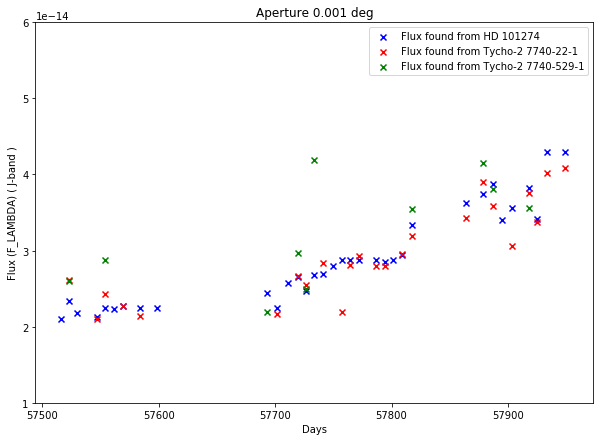

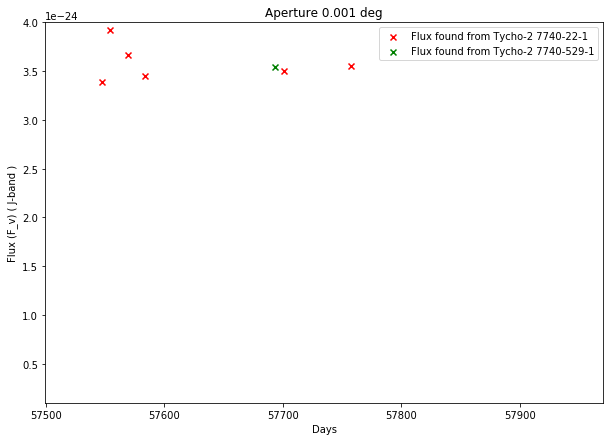

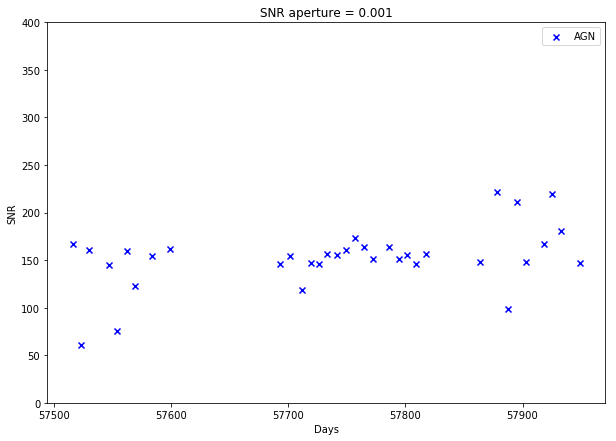

In [17]:
plt.figure(figsize=(10,7))
plt.scatter(date,ABS_FLUX_LAMBDA_1,marker='x',\
            color='b',label='Flux found from HD 101274')
plt.scatter(date,ABS_FLUX_LAMBDA_2,marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date,ABS_FLUX_LAMBDA_3,marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_LAMBDA) ( J-band )')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([1*10**(-14),6*10**(-14)])
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.scatter(date,np.array(ABS_FLUX_V_2),marker='x',\
            color='r',label='Flux found from Tycho-2 7740-22-1')
plt.scatter(date,np.array(ABS_FLUX_V_3),marker='x',\
            color='g',label='Flux found from Tycho-2 7740-529-1')
plt.xlabel('Days')
plt.ylabel('Flux (F_v) ( J-band )')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.ylim([1*10**(-25),0.4*10**(-23)])
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
#plt.scatter(time,err)
plt.scatter(date,SNR1,marker='x',label='AGN',color='b')
#plt.scatter(date,poissonAGN,marker='o',label='Poisson AGN',color='b',alpha=0.4)
#plt.scatter(date,SNR2,marker='x',\
#            label='HD101274')
#plt.scatter(date,SNR2,marker='x',label='HD101274',color='black')
#plt.scatter(date,poissonHD,marker='o',label='Poisson HD101274',color='black',alpha=0.4)

#plt.scatter(date,SNR3,marker='x',label='Tycho-2 7740-22-1',color='r')
#plt.scatter(date,poisson22,marker='o',label='Poisson Tycho-2 7740-22-1',color='r',alpha=0.4)
#plt.scatter(date,SNR4,marker='x',label='Tycho-2 7740-529-1',color='g')
#plt.scatter(date,poisson529,marker='o',label='Poisson Tycho-2 7740-529-1',color='g',alpha=0.4)
#plt.scatter(date,np.array(SNR5),marker='x',\
#            label='Galaxy')
plt.xlabel('Days')
plt.ylabel('SNR')
plt.title('SNR aperture = 0.001')
plt.ylim([0,400])
plt.legend()
plt.show()

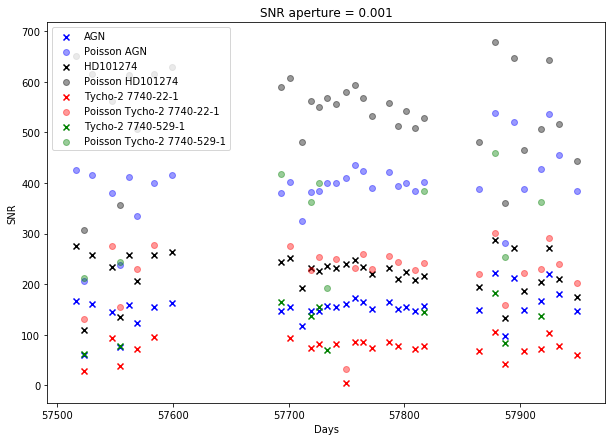

In [18]:
plt.figure(figsize=(10,7))
#plt.scatter(time,err)
plt.scatter(date,SNR1,marker='x',label='AGN',color='b')
plt.scatter(date,poissonAGN,marker='o',label='Poisson AGN',color='b',alpha=0.4)
#plt.scatter(date,SNR2,marker='x',\
#            label='HD101274')
plt.scatter(date,SNR2,marker='x',label='HD101274',color='black')
plt.scatter(date,poissonHD,marker='o',label='Poisson HD101274',color='black',alpha=0.4)

plt.scatter(date,SNR3,marker='x',label='Tycho-2 7740-22-1',color='r')
plt.scatter(date,poisson22,marker='o',label='Poisson Tycho-2 7740-22-1',color='r',alpha=0.4)
plt.scatter(date,SNR4,marker='x',label='Tycho-2 7740-529-1',color='g')
plt.scatter(date,poisson529,marker='o',label='Poisson Tycho-2 7740-529-1',color='g',alpha=0.4)
#plt.scatter(date,np.array(SNR5),marker='x',\
#            label='Galaxy')
plt.xlabel('Days')
plt.ylabel('SNR')
plt.title('SNR aperture = 0.001')
plt.legend()
plt.show()

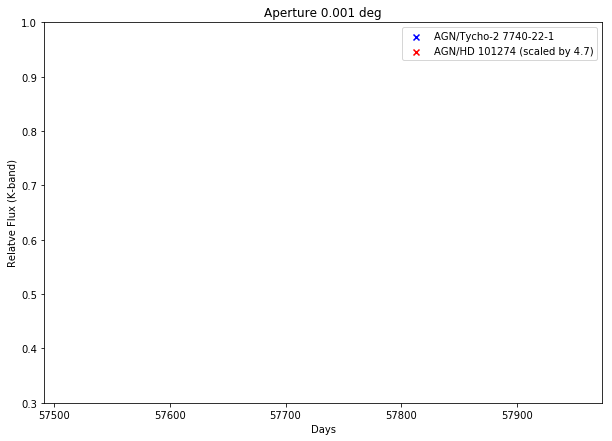

In [19]:
plt.figure(figsize=(10,7))
plt.scatter(date,flucompsta2,marker='x',\
            color='b',label='AGN/Tycho-2 7740-22-1')
plt.scatter(date,flucompsta1*5.8,marker='x',\
            color='r',label='AGN/HD 101274 (scaled by 4.7)')
#plt.scatter(date,flucompsta4*2.2,marker='x',\
#            color='g',label='AGN/Tycho-2 7740-529-1 (scaled by 2.2)')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
plt.ylim([0.3,1.0])
plt.legend()
plt.show()




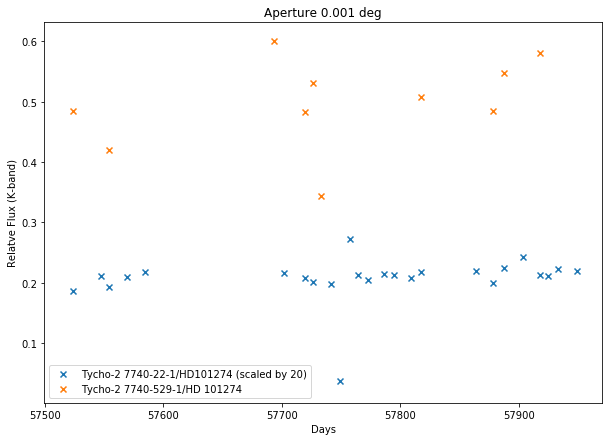

In [20]:

plt.figure(figsize=(10,7))
plt.scatter(date,flucompsta3,marker='x',\
            label='Tycho-2 7740-22-1/HD101274 (scaled by 20)')
plt.scatter(date,flucompsta6,marker='x',\
            label='Tycho-2 7740-529-1/HD 101274')
#plt.scatter(date,np.array(flucompsta7),marker='x',\
#            label='Galaxy/HD 101274')
plt.xlabel('Days')
plt.ylabel('Relatve Flux (K-band)')
plt.title('Aperture 0.001 deg')
#plt.yscale('log')
plt.legend()
plt.show()
